<a href="https://colab.research.google.com/github/splAcharya/Extractive_Text_Summarization/blob/main/ExTs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Extractive Text Summarization Of Wikipedia Articles

## Install Packages (if needed)

In [1]:
#gensim
!pip install --upgrade gensim

#rouge scorer
!pip install rouge-score

## Import Required Libraries

In [2]:
import time
import re
import urllib.request
from bs4 import BeautifulSoup as bs

import string
pm_set = set(list(string.punctuation))

import nltk
from nltk.corpus import stopwords
nltk.download("stopwords")
nltk.download('punkt')
nltk.download('wordnet')
sw_set = set(stopwords.words("english"))

from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer
from gensim.models import Word2Vec
import gensim.downloader
from gensim.models import Phrases


import multiprocessing
num_cores = multiprocessing.cpu_count()
print(f"Number of Cores: {num_cores}")

from wordcloud import WordCloud
from PIL import Image
from matplotlib import pyplot as plt
import numpy as np

from sklearn.utils.extmath import randomized_svd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation as LDA

from copy import deepcopy
from rouge_score import rouge_scorer
import pandas as pd
from collections import Counter, defaultdict

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
Number of Cores: 2


## Function to Webscrape Wikipedia Article

In [3]:
def fetch_wikipedia_article(url="https://en.wikipedia.org/wiki/USA"):
    scrapped_data = urllib.request.urlopen(url)
    article = scrapped_data.read()
    parsed_article = bs(article,"lxml")
    paragraphs = parsed_article.find_all("p")
    article_text = ""
    for p in paragraphs:
        article_text += p.text
    return article_text

## Function to Pre-process Web Scraped Wikipedia Article

In [4]:
def preprocess_article(article, min_length = 5):
    article_lc = article.lower()#lower case entire article
    article_st = sent_tokenize(article_lc)#convert to sentences
    lmtzr = WordNetLemmatizer()#instantiate lemmatize
    pp_article_st = []
    final_article_st = []
    for sentence in article_st:
        original_sentence = deepcopy(sentence)
        #print(sentence)
        sentence = re.sub(r"[\(.*\)]"," ", sentence)#remove data betweena nd include round backers()
        #print(sentence)
        sentence = re.sub(r"\n","",sentence) #remove "\n" characters
        #print(sentence)
        sentence = re.sub(r"\[\d+\]"," ",sentence)#remove refrences [n]
        #print(sentence)
        sentence = re.sub(r"\[.+\]"," ",sentence) #remove anything between [] including []
        #print(sentence)
        sentence = re.sub(r"[^a-zA-z0-9]", " ", sentence) #remove any non english characters
        #print(sentence)
        sentence = re.sub(r"\s+"," ",sentence) #remove any whitespaces, tabs, newline charaacters
        #print(sentence)
        sentence = [lmtzr.lemmatize(word) for word in word_tokenize(sentence) if word not in sw_set ]
        if len(sentence) >= min_length:
            sentence = (" ").join(sentence)
            pp_article_st.append(sentence)
            final_article_st.append(original_sentence)
    return final_article_st, pp_article_st

## Using the two function above to extract Wikipedia Article about USA

In [5]:
article_text = fetch_wikipedia_article("https://en.wikipedia.org/wiki/USA")
article_st, pp_article_st = preprocess_article(article_text)
pp_article_st_wt = [word_tokenize(sent) for sent in pp_article_st]

In [6]:
pp_string = (" ").join(pp_article_st)

In [7]:
article_st[0]

'\n\ncoordinates: .mw-parser-output .geo-default,.mw-parser-output .geo-dms,.mw-parser-output .geo-dec{display:inline}.mw-parser-output .geo-nondefault,.mw-parser-output .geo-multi-punct{display:none}.mw-parser-output .longitude,.mw-parser-output .latitude{white-space:nowrap}40°n 100°w\ufeff / \ufeff40°n 100°w\ufeff / 40; -100\nthe united states of america (u.s.a. or usa), commonly known as the united states (u.s. or us) or america, is a country primarily located in north america.'

In [8]:
pp_article_st[0:5]

['coordinate mw parser output geo default mw parser output geo dm mw parser output geo dec display inline mw parser output geo nondefault mw parser output geo multi punct display none mw parser output longitude mw parser output latitude white space nowrap 40 n 100 w 40 n 100 w 40 100the united state america u usa commonly known united state u u america country primarily located north america',
 'consists 50 state federal district five major unincorporated territory 326 indian reservation minor possession',
 '3 8 million square mile 9 8 million square kilometer world third fourth largest country geographic area',
 'united state share significant land border canada north mexico south well limited maritime border bahamas cuba russia',
 'population 331 million people third populous country world']

## Generate Word Clouds For Raw and Preprocessed Wikipedia Article about USA

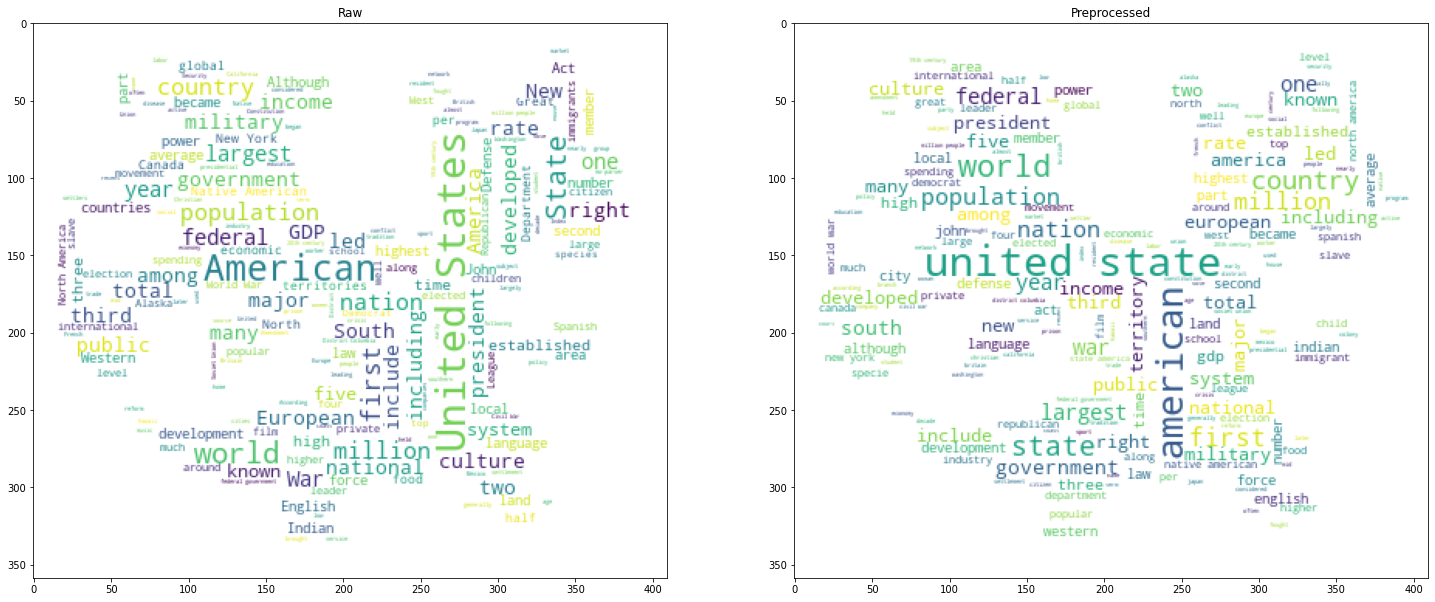

In [9]:
wc_mask = np.array(Image.open(urllib.request.urlopen("http://pm1.narvii.com/5750/abb7fdf1f24f9515a1f1d16e6f05d3f03110c51f_00.jpg")))
wc = WordCloud(background_color="white",mask=wc_mask)
fig, ax = plt.subplots(1,2,figsize=(25,25))
ax[0].imshow(wc.generate(article_text))
ax[0].title.set_text("Raw")
ax[1].imshow(wc.generate(pp_string))
ax[1].title.set_text("Preprocessed")
plt.show()

## LSA Summary Generators

### Function to Generate BOW + LSA Summary

In [10]:
def generate_bow_lsa_summary(raw_sent_tokens, pp_sent_tokens, summary_size = 10, ngram_tuple=(1,1)):
  count_vectorizer = CountVectorizer(ngram_range=ngram_tuple)
  feature_vector = count_vectorizer.fit_transform(pp_sent_tokens)
  U, SIGMA, VT = randomized_svd(feature_vector, n_components = summary_size, n_iter = 100, random_state =100)
  sentence_scores = np.sqrt(np.dot(U**2, SIGMA**2))
  top_scores_index = np.argsort(sentence_scores)[::-1]
  top_scores_index = top_scores_index[0:summary_size]
  article_array = np.array(raw_sent_tokens)
  bow_sum = list(article_array[top_scores_index])
  bow_sum_str = " ".join(bow_sum)
  return bow_sum_str

### Function to Generate TF-IDF + LSA Summary

In [11]:
def generate_tfidf_lsa_summary(raw_sent_tokens, pp_sent_tokens, summary_size = 10, ngram_tuple=(1,1)):
  tfidf_vectorizer = TfidfVectorizer(ngram_range=ngram_tuple)
  feature_vector = tfidf_vectorizer.fit_transform(pp_sent_tokens)
  U, SIGMA, VT = randomized_svd(feature_vector, n_components = summary_size, n_iter = 100, random_state =100)
  sentence_scores = np.sqrt(np.dot(U**2, SIGMA**2))
  top_scores_index = np.argsort(sentence_scores)[::-1]
  top_scores_index = top_scores_index[0:summary_size]
  article_array = np.array(raw_sent_tokens)
  tfidf_sum = list(article_array[top_scores_index])
  tfidf_sum_str = " ".join(tfidf_sum)
  return tfidf_sum_str

### Function to Generate Word Embedding + LSA Summary

In [12]:
def create_word_to_vec_model(pp_sent_tokens, ngram=1):

  #create work tokens
  pp_article_st_wt = [word_tokenize(sent) for sent in pp_sent_tokens]

  if ngram <= 1:
    w2v_model = Word2Vec(sentences=pp_article_st_wt,
                        min_count = 5, 
                        window = 5,
                        vector_size=10,
                        sample=6e-5,
                        alpha=0.001,
                        min_alpha = 0.0007,
                        negative=20,
                        workers=num_cores-2)   
    return w2v_model

  else:
    #create n gram phraser
    ngram_model = None
    for i in range(2, ngram+1):
      ngram_model = gensim.models.phrases.Phrases(pp_article_st_wt)

    #create wor2vec model
    w2v_model = Word2Vec(sentences=ngram_model[pp_article_st_wt],
                          min_count = 5, 
                          window = 5,
                          vector_size=10,
                          sample=6e-5,
                          alpha=0.001,
                          min_alpha = 0.0007,
                          negative=20,
                          workers=num_cores-2)  

    return w2v_model

In [13]:
def generate_wemb_lsa_summary(raw_sent_tokens, pp_sent_tokens, summary_size = 10, ngram = 1):

  #get word 2 vec model
  w2v_model = create_word_to_vec_model(pp_sent_tokens, ngram)#get w2v model
  
  #get word 2 vec model
  words = list(w2v_model.wv.index_to_key)
  word_emb_list = sorted(words)

  #create pandas dataframe 
  document_term_emb = np.zeros(shape=(len(pp_article_st_wt), len(word_emb_list)))
  dte_df = pd.DataFrame(document_term_emb)
  dte_df.columns = word_emb_list
  for i in range(len(pp_article_st)):
    freq_map = Counter(pp_article_st[i])
    for word in word_emb_list:
      if freq_map[word] > 0:
        dte_df[word].iloc[i] += np.median(w2v_model.wv[word])
        freq_map[word] -= 1  

  feature_vector = dte_df.to_numpy()
  U, SIGMA, VT = randomized_svd(feature_vector, n_components = summary_size, n_iter = 100, random_state =100)
  sentence_scores = np.sqrt(np.dot(U**2, SIGMA**2))
  top_scores_index = np.argsort(sentence_scores)[::-1]
  top_scores_index = top_scores_index[0:summary_size]
  article_array = np.array(raw_sent_tokens)
  wemb_sum = list(article_array[top_scores_index])
  wemb_sum_str = " ".join(wemb_sum)
  return wemb_sum_str

## LDA Summary Generators

### Function to Generate BOW + LDA Summary

In [23]:
def generate_bow_lda_summary(raw_sent_tokens, pp_sent_tokens, summary_size = 10, ngram_tuple=(1,1)):

  #get BOW Features
  count_vectorizer = CountVectorizer(ngram_range=ngram_tuple) #intialize
  feature_vector = count_vectorizer.fit_transform(pp_sent_tokens) #generate
  print("BOW Features Generated!!!")

  #get LDA features
  lda_model = LDA(n_components=summary_size, random_state=0, max_iter = 100)
  document_topic_vector = lda_model.fit_transform(feature_vector)
  print("LDA Features Generated!!!")

  #
  #generatee summaries based on LDA probabilibities
  #

  sorted_probabilities = np.argsort(document_topic_vector, axis = 1) 
  top_probabilities = sorted_probabilities[:,-1]
  topic_bins = defaultdict(list)

  for i in range(document_topic_vector.shape[0]):
    topic_num = sorted_probabilities[i][-1]
    sent_index = i
    prob = document_topic_vector[i,sorted_probabilities[i][-1]]
    topic_bins[topic_num].append((sent_index, prob))

  print("Topic Bins Generated!!!")

  for k, v in topic_bins.items():
    topic_bins[k] = sorted(v, key=lambda x:x[1]) 

  topic_bins_keys = sorted(topic_bins.keys())
  topic_bin_list = [None] * document_topic_vector.shape[0]
  for tindex in topic_bins_keys:
    topic_bin_list[tindex] = topic_bins[tindex]

  print("Topic Bins List Generated!!!\n")

  sentences = []
  index = 0
  count = 0
  while count < N_LINE and topic_bin_list:
    index = index % len(topic_bin_list)
    if topic_bin_list[index]:
      sentences.append(topic_bin_list[index].pop())
      count += 1
    index += 1

  sentences = sorted(sentences, key=lambda x:x[0])
  summary = []
  for idx, prob in sentences:
    summary.append(article_st[idx])

  return "".join(summary)
  #return summary

### Function to Generate TF-IDF + LDA Summary

In [24]:
def generate_tfidf_lda_summary(raw_sent_tokens, pp_sent_tokens, summary_size = 10, ngram_tuple=(1,1)):

  #get TFIDF Features
  tfidf_vectorizer = TfidfVectorizer(ngram_range=ngram_tuple)
  feature_vector = tfidf_vectorizer.fit_transform(pp_sent_tokens)
  print("BOW Features Generated!!!")

  #get LDA features
  lda_model = LDA(n_components=summary_size, random_state=0, max_iter = 100)
  document_topic_vector = lda_model.fit_transform(feature_vector)
  print("LDA Features Generated!!!")

  #
  #generatee summaries based on LDA probabilibities
  #

  sorted_probabilities = np.argsort(document_topic_vector, axis = 1) 
  top_probabilities = sorted_probabilities[:,-1]
  topic_bins = defaultdict(list)

  for i in range(document_topic_vector.shape[0]):
    topic_num = sorted_probabilities[i][-1]
    sent_index = i
    prob = document_topic_vector[i,sorted_probabilities[i][-1]]
    topic_bins[topic_num].append((sent_index, prob))

  print("Topic Bins Generated!!!")

  for k, v in topic_bins.items():
    topic_bins[k] = sorted(v, key=lambda x:x[1]) 

  topic_bins_keys = sorted(topic_bins.keys())
  topic_bin_list = [None] * document_topic_vector.shape[0]
  for tindex in topic_bins_keys:
    topic_bin_list[tindex] = topic_bins[tindex]

  print("Topic Bins List Generated!!!\n")

  sentences = []
  index = 0
  count = 0
  while count < N_LINE and topic_bin_list:
    index = index % len(topic_bin_list)
    if topic_bin_list[index]:
      sentences.append(topic_bin_list[index].pop())
      count += 1
    index += 1

  sentences = sorted(sentences, key=lambda x:x[0])
  summary = []
  for idx, prob in sentences:
    summary.append(article_st[idx])

  return "".join(summary)

### Function to Generate Word Embedding + LDA Summary

In [25]:
def generate_wemb_lda_summary(raw_sent_tokens, pp_sent_tokens, summary_size = 10, ngram = 1):

  #get word 2 vec model
  w2v_model = create_word_to_vec_model(pp_sent_tokens, ngram)#get w2v model
  
  #get word 2 vec model
  words = list(w2v_model.wv.index_to_key)
  word_emb_list = sorted(words)

  #create pandas dataframe for feature vector
  document_term_emb = np.zeros(shape=(len(pp_article_st_wt), len(word_emb_list)))
  dte_df = pd.DataFrame(document_term_emb)
  dte_df.columns = word_emb_list
  for i in range(len(pp_article_st)):
    freq_map = Counter(pp_article_st[i])
    for word in word_emb_list:
      if freq_map[word] > 0:
        dte_df[word].iloc[i] += abs(np.median(w2v_model.wv[word]))
        freq_map[word] -= 1  

  #convert feature vector from dataframe to numpy
  feature_vector = dte_df.to_numpy()
  print("Wemb Features Generated!!!")

  #get LDA features
  lda_model = LDA(n_components=summary_size, random_state=0, max_iter = 100)
  document_topic_vector = lda_model.fit_transform(feature_vector)
  print("LDA Features Generated!!!")

  #
  #generatee summaries based on LDA probabilibities
  #

  sorted_probabilities = np.argsort(document_topic_vector, axis = 1) 
  top_probabilities = sorted_probabilities[:,-1]
  topic_bins = defaultdict(list)

  for i in range(document_topic_vector.shape[0]):
    topic_num = sorted_probabilities[i][-1]
    sent_index = i
    prob = document_topic_vector[i,sorted_probabilities[i][-1]]
    topic_bins[topic_num].append((sent_index, prob))

  print("Topic Bins Generated!!!")

  for k, v in topic_bins.items():
    topic_bins[k] = sorted(v, key=lambda x:x[1]) 

  topic_bins_keys = sorted(topic_bins.keys())
  topic_bin_list = [None] * document_topic_vector.shape[0]
  for tindex in topic_bins_keys:
    topic_bin_list[tindex] = topic_bins[tindex]

  print("Topic Bins List Generated!!!\n")

  sentences = []
  index = 0
  count = 0
  while count < N_LINE and topic_bin_list:
    index = index % len(topic_bin_list)
    if topic_bin_list[index]:
      sentences.append(topic_bin_list[index].pop())
      count += 1
    index += 1

  sentences = sorted(sentences, key=lambda x:x[0])
  summary = []
  for idx, prob in sentences:
    summary.append(article_st[idx])

  return "".join(summary)

## Number of Lines in Summary

In [26]:
N_LINE = 10

## Generate Summaries for Uni-GRAM (1-GRAM) Occurence

### LSA

#### BOW

In [27]:
bow_lsa_1gram_summary = generate_bow_lsa_summary(article_st, pp_article_st, N_LINE, (1,1))
bow_lsa_1gram_summary

'\n\ncoordinates: .mw-parser-output .geo-default,.mw-parser-output .geo-dms,.mw-parser-output .geo-dec{display:inline}.mw-parser-output .geo-nondefault,.mw-parser-output .geo-multi-punct{display:none}.mw-parser-output .longitude,.mw-parser-output .latitude{white-space:nowrap}40°n 100°w\ufeff / \ufeff40°n 100°w\ufeff / 40; -100\nthe united states of america (u.s.a. or usa), commonly known as the united states (u.s. or us) or america, is a country primarily located in north america. [421]\nthe centers for disease control and prevention (cdc) reported that the united states had an average life expectancy at birth of 77.3 years in 2020 (74.5 years for men and 80.2 years for women), down 1.5 years from 2019. according to provisional figures, this was the lowest average u.s. life expectancy recorded by the cdc since 2003, the first overall decline since 2018, and "the largest one-year decline since world war ii." other languages spoken at home by one million people or more include chinese (2

#### TF-IDF

In [28]:
tfidf_lsa_1gram_summary = generate_tfidf_lsa_summary(article_st, pp_article_st, N_LINE, (1,1))
tfidf_lsa_1gram_summary

"other languages spoken at home by one million people or more include chinese (2.8 million), tagalog (1.6 million), vietnamese (1.4 million), french (1.3 million), korean (1.1 million), and german (1 million). the united states is one of the few countries in the world to do so. the spanish–american war and world war i established the u.s. as a world power, and the aftermath of world war ii left the united states and the soviet union as the world's two superpowers. the united states has the world's largest christian population. the district of columbia and the five major u.s. territories do not have senators. [231] the states and the district of columbia choose the president of the united states. the district of columbia and the five major u.s. territories each have one member of congress—these members are not allowed to vote. by value, the united states is the world's largest importer and second-largest exporter of goods. [22] with a population of more than 331 million people, it is th

#### Word-Embeddings

In [29]:
wemb_lsa_1gram_summary = generate_wemb_lsa_summary(article_st, pp_article_st, summary_size = 10, ngram = 1)
wemb_lsa_1gram_summary

'[288] defense\'s share of the overall u.s. economy has generally declined in recent decades, from early cold war peaks of 14.2% of gdp in 1953 and 69.5% of federal spending in 1954 to 4.7% of gdp and 18.8% of federal spending in 2011. [360][361][362][363] in 2011, 16.7 million children lived in food-insecure households, about 35% more than 2007 levels, though only 845,000 u.s. children (1.1%) saw reduced food intake or disrupted eating patterns at some point during the year, and most cases were not chronic. [195] the united states is home to 428 mammal species, 784 bird species, 311 reptile species, and 295 amphibian species,[196] as well as about 91,000 insect species. [421]\nthe centers for disease control and prevention (cdc) reported that the united states had an average life expectancy at birth of 77.3 years in 2020 (74.5 years for men and 80.2 years for women), down 1.5 years from 2019. according to provisional figures, this was the lowest average u.s. life expectancy recorded b

### LDA

#### BOW

In [30]:
bow_lda_1gram_summary = generate_bow_lda_summary(article_st, pp_article_st, N_LINE, (1,1))
bow_lda_1gram_summary

BOW Features Generated!!!
LDA Features Generated!!!
Topic Bins Generated!!!
Topic Bins List Generated!!!



'\n\ncoordinates: .mw-parser-output .geo-default,.mw-parser-output .geo-dms,.mw-parser-output .geo-dec{display:inline}.mw-parser-output .geo-nondefault,.mw-parser-output .geo-multi-punct{display:none}.mw-parser-output .longitude,.mw-parser-output .latitude{white-space:nowrap}40°n 100°w\ufeff / \ufeff40°n 100°w\ufeff / 40; -100\nthe united states of america (u.s.a. or usa), commonly known as the united states (u.s. or us) or america, is a country primarily located in north america.[44] anthropologist henry f. dobyns believed the populations were much higher, suggesting around 1.1 million along the shores of the gulf of mexico, 2.2 million people living between florida and massachusetts, 5.2 million in the mississippi valley and tributaries, and around 700,000 people in the florida peninsula.they persisted until the compromise of 1877 when the republicans agreed to cease protecting the rights of african americans in the south in order for democrats to concede the presidential election of

#### TF-IDF

In [31]:
tfidf_lda_1gram_summary = generate_tfidf_lda_summary(article_st, pp_article_st, N_LINE, (1,1))
tfidf_lda_1gram_summary

BOW Features Generated!!!
LDA Features Generated!!!
Topic Bins Generated!!!
Topic Bins List Generated!!!



'[33]\nit has been generally accepted that the first inhabitants of north america migrated from siberia by way of the bering land bridge and arrived at least 12,000 years ago; however, some evidence suggests an even earlier date of arrival.the first documented arrival of europeans in the continental united states is that of spanish conquistadors such as juan ponce de león, who made his first expedition to florida in 1513. even earlier, christopher columbus had landed in puerto rico on his 1493 voyage, and san juan was settled by the spanish a decade later.[86] the 1803 louisiana purchase almost doubled the nation\'s area,[87] spain ceded florida and other gulf coast territory in 1819,[88] the republic of texas was annexed in 1845 during a period of expansionism,[89] and the 1846 oregon treaty with britain led to u.s. control of the present-day american northwest.they persisted until the compromise of 1877 when the republicans agreed to cease protecting the rights of african americans i

#### Word-Embeddings

In [32]:
wemb_lda_1gram_summary = generate_wemb_lda_summary(article_st, pp_article_st, summary_size = 10, ngram = 1)
wemb_lda_1gram_summary

Wemb Features Generated!!!
LDA Features Generated!!!
Topic Bins Generated!!!
Topic Bins List Generated!!!



'after his election, president ronald reagan responded to economic stagnation with free-market oriented reforms.[195] the united states is home to 428 mammal species, 784 bird species, 311 reptile species, and 295 amphibian species,[196] as well as about 91,000 insect species.[240] the president and vice president are elected by the electoral college.[264] both non-resident citizens and green card holders living abroad are taxed on their income irrespective of where they live or where their income is earned.the department of defense administers five of the six service branches, which are made up of the army, marine corps, navy, air force, and space force.[288] defense\'s share of the overall u.s. economy has generally declined in recent decades, from early cold war peaks of 14.2% of gdp in 1953 and 69.5% of federal spending in 1954 to 4.7% of gdp and 18.8% of federal spending in 2011.[296] the department of justice said that the imprisonment rate for all prisoners sentenced to more tha

## Generate Summaries For BI-GRAM (2-GRAM) Occurence

### LSA

#### BOW

In [36]:
bow_lsa_2gram_summary = generate_bow_lsa_summary(article_st, pp_article_st, N_LINE, (2,2))
bow_lsa_2gram_summary

'\n\ncoordinates: .mw-parser-output .geo-default,.mw-parser-output .geo-dms,.mw-parser-output .geo-dec{display:inline}.mw-parser-output .geo-nondefault,.mw-parser-output .geo-multi-punct{display:none}.mw-parser-output .longitude,.mw-parser-output .latitude{white-space:nowrap}40°n 100°w\ufeff / \ufeff40°n 100°w\ufeff / 40; -100\nthe united states of america (u.s.a. or usa), commonly known as the united states (u.s. or us) or america, is a country primarily located in north america. [533] in soccer (a sport that has gained a footing in the united states since the mid-1990s), the country hosted the 1994 fifa world cup, the men\'s national soccer team qualified for ten world cups and the women\'s team has won the fifa women\'s world cup four times; major league soccer is the sport\'s highest league in the united states (featuring 23 american and three canadian teams). [421]\nthe centers for disease control and prevention (cdc) reported that the united states had an average life expectancy 

#### TF-IDF

In [37]:
tfidf_lsa_2gram_summary = generate_tfidf_lsa_summary(article_st, pp_article_st, N_LINE, (2,2))
tfidf_lsa_2gram_summary

"it is a permanent member of the united nations security council, and new york city is home to the united nations headquarters. it is a permanent member of the united nations security council. the district of columbia and the five major u.s. territories do not have senators. the united states is one of the few countries in the world to do so. by value, the united states is the world's largest importer and second-largest exporter of goods. the district of columbia and the five major u.s. territories each have one member of congress—these members are not allowed to vote. the united states has the world's largest christian population. the spanish–american war and world war i established the u.s. as a world power, and the aftermath of world war ii left the united states and the soviet union as the world's two superpowers. the national capital is washington, d.c., and the most populous city is new york city. [213]\nthe united states is a federal republic of 50 states, a federal district, fi

#### Word-Embeddings

In [38]:
wemb_lsa_2gram_summary = generate_wemb_lsa_summary(article_st, pp_article_st, summary_size = 10, ngram = 2)
wemb_lsa_2gram_summary

'[288] defense\'s share of the overall u.s. economy has generally declined in recent decades, from early cold war peaks of 14.2% of gdp in 1953 and 69.5% of federal spending in 1954 to 4.7% of gdp and 18.8% of federal spending in 2011. [360][361][362][363] in 2011, 16.7 million children lived in food-insecure households, about 35% more than 2007 levels, though only 845,000 u.s. children (1.1%) saw reduced food intake or disrupted eating patterns at some point during the year, and most cases were not chronic. [195] the united states is home to 428 mammal species, 784 bird species, 311 reptile species, and 295 amphibian species,[196] as well as about 91,000 insect species. [421]\nthe centers for disease control and prevention (cdc) reported that the united states had an average life expectancy at birth of 77.3 years in 2020 (74.5 years for men and 80.2 years for women), down 1.5 years from 2019. according to provisional figures, this was the lowest average u.s. life expectancy recorded b

### LDA

#### BOW

In [39]:
bow_lda_2gram_summary = generate_bow_lda_summary(article_st, pp_article_st, N_LINE, (2,2))
bow_lda_2gram_summary

BOW Features Generated!!!
LDA Features Generated!!!
Topic Bins Generated!!!
Topic Bins List Generated!!!



'\n\ncoordinates: .mw-parser-output .geo-default,.mw-parser-output .geo-dms,.mw-parser-output .geo-dec{display:inline}.mw-parser-output .geo-nondefault,.mw-parser-output .geo-multi-punct{display:none}.mw-parser-output .longitude,.mw-parser-output .latitude{white-space:nowrap}40°n 100°w\ufeff / \ufeff40°n 100°w\ufeff / 40; -100\nthe united states of america (u.s.a. or usa), commonly known as the united states (u.s. or us) or america, is a country primarily located in north america.they persisted until the compromise of 1877 when the republicans agreed to cease protecting the rights of african americans in the south in order for democrats to concede the presidential election of 1876.\nsouthern white democrats, calling themselves "redeemers", took control of the south after the end of reconstruction, beginning the nadir of american race relations.[164]\ngovernment policy designed to promote affordable housing,[165] widespread failures in corporate and regulatory governance,[166] and histo

#### TF-IDF

In [40]:
tfidf_lda_2gram_summary = generate_tfidf_lda_summary(article_st, pp_article_st, N_LINE, (2,2))
tfidf_lda_2gram_summary

BOW Features Generated!!!
LDA Features Generated!!!
Topic Bins Generated!!!
Topic Bins List Generated!!!



'they persisted until the compromise of 1877 when the republicans agreed to cease protecting the rights of african americans in the south in order for democrats to concede the presidential election of 1876.\nsouthern white democrats, calling themselves "redeemers", took control of the south after the end of reconstruction, beginning the nadir of american race relations.[164]\ngovernment policy designed to promote affordable housing,[165] widespread failures in corporate and regulatory governance,[166] and historically low interest rates set by the federal reserve[167] led to the united states housing bubble in 2006, which culminated with the financial crisis of 2007–2008 and the great recession, the nation\'s largest economic contraction since the great depression.since the general election of 1856, the major parties have been the democratic party, founded in 1824, and the republican party, founded in 1854. since the civil war, only one third-party presidential candidate—former preside

#### Word-Embeddings

In [41]:
wemb_lda_2gram_summary = generate_wemb_lda_summary(article_st, pp_article_st, summary_size = 10, ngram = 2)
wemb_lda_2gram_summary

Wemb Features Generated!!!
LDA Features Generated!!!
Topic Bins Generated!!!
Topic Bins List Generated!!!



'after his election, president ronald reagan responded to economic stagnation with free-market oriented reforms.[195] the united states is home to 428 mammal species, 784 bird species, 311 reptile species, and 295 amphibian species,[196] as well as about 91,000 insect species.[240] the president and vice president are elected by the electoral college.[264] both non-resident citizens and green card holders living abroad are taxed on their income irrespective of where they live or where their income is earned.the department of defense administers five of the six service branches, which are made up of the army, marine corps, navy, air force, and space force.[288] defense\'s share of the overall u.s. economy has generally declined in recent decades, from early cold war peaks of 14.2% of gdp in 1953 and 69.5% of federal spending in 1954 to 4.7% of gdp and 18.8% of federal spending in 2011.[360][361][362][363] in 2011, 16.7 million children lived in food-insecure households, about 35% more t

## Generate Summaries For Tri-GRAM (3-GRAM) Occurence

### LSA

#### BOW

In [42]:
bow_lsa_3gram_summary = generate_bow_lsa_summary(article_st, pp_article_st, N_LINE, (3,3))
bow_lsa_3gram_summary

'\n\ncoordinates: .mw-parser-output .geo-default,.mw-parser-output .geo-dms,.mw-parser-output .geo-dec{display:inline}.mw-parser-output .geo-nondefault,.mw-parser-output .geo-multi-punct{display:none}.mw-parser-output .longitude,.mw-parser-output .latitude{white-space:nowrap}40°n 100°w\ufeff / \ufeff40°n 100°w\ufeff / 40; -100\nthe united states of america (u.s.a. or usa), commonly known as the united states (u.s. or us) or america, is a country primarily located in north america. notable films topping the american film institute\'s afi 100 list include orson welles\'s citizen kane (1941), which is frequently cited as the greatest film of all time,[520][521] casablanca (1942), the godfather (1972), gone with the wind (1939), lawrence of arabia (1962), the wizard of oz (1939), the graduate (1967), on the waterfront (1954), schindler\'s list (1993), singin\' in the rain (1952), it\'s a wonderful life (1946) and sunset boulevard (1950). [421]\nthe centers for disease control and preventio

#### TF-IDF

In [43]:
tfidf_lsa_3gram_summary = generate_tfidf_lsa_summary(article_st, pp_article_st, N_LINE, (3,3))
tfidf_lsa_3gram_summary

"it is a permanent member of the united nations security council. it is a permanent member of the united nations security council, and new york city is home to the united nations headquarters. the district of columbia and the five major u.s. territories do not have senators. the district of columbia and the five major u.s. territories each have one member of congress—these members are not allowed to vote. [548]\nmore than 800 publications are produced in spanish, the second most commonly used language in the united states behind english. more than 37 million spoke spanish at home, making it the second most commonly used language in the united states. the united states is one of the few countries in the world to do so. the united states has the world's largest christian population. [231] the states and the district of columbia choose the president of the united states. by value, the united states is the world's largest importer and second-largest exporter of goods."

#### Word-Embeddings

In [44]:
wemb_lsa_3gram_summary = generate_wemb_lsa_summary(article_st, pp_article_st, summary_size = 10, ngram = 3)
wemb_lsa_3gram_summary

'[288] defense\'s share of the overall u.s. economy has generally declined in recent decades, from early cold war peaks of 14.2% of gdp in 1953 and 69.5% of federal spending in 1954 to 4.7% of gdp and 18.8% of federal spending in 2011. [360][361][362][363] in 2011, 16.7 million children lived in food-insecure households, about 35% more than 2007 levels, though only 845,000 u.s. children (1.1%) saw reduced food intake or disrupted eating patterns at some point during the year, and most cases were not chronic. [195] the united states is home to 428 mammal species, 784 bird species, 311 reptile species, and 295 amphibian species,[196] as well as about 91,000 insect species. [421]\nthe centers for disease control and prevention (cdc) reported that the united states had an average life expectancy at birth of 77.3 years in 2020 (74.5 years for men and 80.2 years for women), down 1.5 years from 2019. according to provisional figures, this was the lowest average u.s. life expectancy recorded b

### LDA

#### BOW

In [45]:
bow_lda_3gram_summary = generate_bow_lda_summary(article_st, pp_article_st, N_LINE, (3,3))
bow_lda_3gram_summary

BOW Features Generated!!!
LDA Features Generated!!!
Topic Bins Generated!!!
Topic Bins List Generated!!!



'\n\ncoordinates: .mw-parser-output .geo-default,.mw-parser-output .geo-dms,.mw-parser-output .geo-dec{display:inline}.mw-parser-output .geo-nondefault,.mw-parser-output .geo-multi-punct{display:none}.mw-parser-output .longitude,.mw-parser-output .latitude{white-space:nowrap}40°n 100°w\ufeff / \ufeff40°n 100°w\ufeff / 40; -100\nthe united states of america (u.s.a. or usa), commonly known as the united states (u.s. or us) or america, is a country primarily located in north america.[164]\ngovernment policy designed to promote affordable housing,[165] widespread failures in corporate and regulatory governance,[166] and historically low interest rates set by the federal reserve[167] led to the united states housing bubble in 2006, which culminated with the financial crisis of 2007–2008 and the great recession, the nation\'s largest economic contraction since the great depression.[169] barack obama, the first multiracial[170] president, with african-american ancestry was elected in 2008 ami

#### TF-IDF

In [46]:
tfidf_lda_3gram_summary = generate_tfidf_lda_summary(article_st, pp_article_st, N_LINE, (3,3))
tfidf_lda_3gram_summary

BOW Features Generated!!!
LDA Features Generated!!!
Topic Bins Generated!!!
Topic Bins List Generated!!!



'\n\ncoordinates: .mw-parser-output .geo-default,.mw-parser-output .geo-dms,.mw-parser-output .geo-dec{display:inline}.mw-parser-output .geo-nondefault,.mw-parser-output .geo-multi-punct{display:none}.mw-parser-output .longitude,.mw-parser-output .latitude{white-space:nowrap}40°n 100°w\ufeff / \ufeff40°n 100°w\ufeff / 40; -100\nthe united states of america (u.s.a. or usa), commonly known as the united states (u.s. or us) or america, is a country primarily located in north america.[69]\nthe thirteen colonies (new hampshire, massachusetts, connecticut, rhode island, new york, new jersey, pennsylvania, delaware, maryland, virginia, north carolina, south carolina, and georgia) that would become the united states of america were administered by the british as overseas dependencies.[169] barack obama, the first multiracial[170] president, with african-american ancestry was elected in 2008 amid the crisis,[171] and subsequently passed american recovery and reinvestment act of 2009 economic st

#### Word-Embeddings

In [47]:
wemb_lda_3gram_summary = generate_wemb_lda_summary(article_st, pp_article_st, summary_size = 10, ngram = 3)
wemb_lda_3gram_summary

Wemb Features Generated!!!
LDA Features Generated!!!
Topic Bins Generated!!!
Topic Bins List Generated!!!



'after his election, president ronald reagan responded to economic stagnation with free-market oriented reforms.[195] the united states is home to 428 mammal species, 784 bird species, 311 reptile species, and 295 amphibian species,[196] as well as about 91,000 insect species.[240] the president and vice president are elected by the electoral college.[264] both non-resident citizens and green card holders living abroad are taxed on their income irrespective of where they live or where their income is earned.the department of defense administers five of the six service branches, which are made up of the army, marine corps, navy, air force, and space force.[288] defense\'s share of the overall u.s. economy has generally declined in recent decades, from early cold war peaks of 14.2% of gdp in 1953 and 69.5% of federal spending in 1954 to 4.7% of gdp and 18.8% of federal spending in 2011.[360][361][362][363] in 2011, 16.7 million children lived in food-insecure households, about 35% more t

## Generate Feaure Matrixes and Summaries For (4-GRAM) Occurence

### LSA

#### BOW

In [48]:
bow_lsa_4gram_summary = generate_bow_lsa_summary(article_st, pp_article_st, N_LINE, (4,4))
bow_lsa_4gram_summary

'\n\ncoordinates: .mw-parser-output .geo-default,.mw-parser-output .geo-dms,.mw-parser-output .geo-dec{display:inline}.mw-parser-output .geo-nondefault,.mw-parser-output .geo-multi-punct{display:none}.mw-parser-output .longitude,.mw-parser-output .latitude{white-space:nowrap}40°n 100°w\ufeff / \ufeff40°n 100°w\ufeff / 40; -100\nthe united states of america (u.s.a. or usa), commonly known as the united states (u.s. or us) or america, is a country primarily located in north america. notable films topping the american film institute\'s afi 100 list include orson welles\'s citizen kane (1941), which is frequently cited as the greatest film of all time,[520][521] casablanca (1942), the godfather (1972), gone with the wind (1939), lawrence of arabia (1962), the wizard of oz (1939), the graduate (1967), on the waterfront (1954), schindler\'s list (1993), singin\' in the rain (1952), it\'s a wonderful life (1946) and sunset boulevard (1950). [421]\nthe centers for disease control and preventio

#### TF-IDF

In [49]:
tfidf_lsa_4gram_summary = generate_tfidf_lsa_summary(article_st, pp_article_st, N_LINE, (4,4))
tfidf_lsa_4gram_summary

'it is a permanent member of the united nations security council. it is a permanent member of the united nations security council, and new york city is home to the united nations headquarters. the district of columbia and the five major u.s. territories each have one member of congress—these members are not allowed to vote. the district of columbia and the five major u.s. territories do not have senators. [548]\nmore than 800 publications are produced in spanish, the second most commonly used language in the united states behind english. more than 37 million spoke spanish at home, making it the second most commonly used language in the united states. it consists of 50 states, a federal district, five major unincorporated territories, 326 indian reservations, and some minor possessions. [213]\nthe united states is a federal republic of 50 states, a federal district, five territories and several uninhabited island possessions. [132][133]\nafter world war ii, the united states and the sov

#### Word-Embeddings

In [50]:
wemb_lsa_4gram_summary = generate_wemb_lsa_summary(article_st, pp_article_st, summary_size = 10, ngram = 4)
wemb_lsa_4gram_summary

'[288] defense\'s share of the overall u.s. economy has generally declined in recent decades, from early cold war peaks of 14.2% of gdp in 1953 and 69.5% of federal spending in 1954 to 4.7% of gdp and 18.8% of federal spending in 2011. [360][361][362][363] in 2011, 16.7 million children lived in food-insecure households, about 35% more than 2007 levels, though only 845,000 u.s. children (1.1%) saw reduced food intake or disrupted eating patterns at some point during the year, and most cases were not chronic. [195] the united states is home to 428 mammal species, 784 bird species, 311 reptile species, and 295 amphibian species,[196] as well as about 91,000 insect species. [421]\nthe centers for disease control and prevention (cdc) reported that the united states had an average life expectancy at birth of 77.3 years in 2020 (74.5 years for men and 80.2 years for women), down 1.5 years from 2019. according to provisional figures, this was the lowest average u.s. life expectancy recorded b

### LDA

#### BOW

In [51]:
bow_lda_4gram_summary = generate_bow_lda_summary(article_st, pp_article_st, N_LINE, (4,4))
bow_lda_4gram_summary

BOW Features Generated!!!
LDA Features Generated!!!
Topic Bins Generated!!!
Topic Bins List Generated!!!



'\n\ncoordinates: .mw-parser-output .geo-default,.mw-parser-output .geo-dms,.mw-parser-output .geo-dec{display:inline}.mw-parser-output .geo-nondefault,.mw-parser-output .geo-multi-punct{display:none}.mw-parser-output .longitude,.mw-parser-output .latitude{white-space:nowrap}40°n 100°w\ufeff / \ufeff40°n 100°w\ufeff / 40; -100\nthe united states of america (u.s.a. or usa), commonly known as the united states (u.s. or us) or america, is a country primarily located in north america.the first documented arrival of europeans in the continental united states is that of spanish conquistadors such as juan ponce de león, who made his first expedition to florida in 1513. even earlier, christopher columbus had landed in puerto rico on his 1493 voyage, and san juan was settled by the spanish a decade later.[249]\nthe united states has a "special relationship" with the united kingdom[250] and strong ties with canada,[251] india, australia,[252] new zealand,[253] the philippines,[254] japan,[255] s

#### TF-IDF

In [52]:
tfidf_lda_4gram_summary = generate_tfidf_lda_summary(article_st, pp_article_st, N_LINE, (4,4))
tfidf_lda_4gram_summary

BOW Features Generated!!!
LDA Features Generated!!!
Topic Bins Generated!!!
Topic Bins List Generated!!!



'\n\ncoordinates: .mw-parser-output .geo-default,.mw-parser-output .geo-dms,.mw-parser-output .geo-dec{display:inline}.mw-parser-output .geo-nondefault,.mw-parser-output .geo-multi-punct{display:none}.mw-parser-output .longitude,.mw-parser-output .latitude{white-space:nowrap}40°n 100°w\ufeff / \ufeff40°n 100°w\ufeff / 40; -100\nthe united states of america (u.s.a. or usa), commonly known as the united states (u.s. or us) or america, is a country primarily located in north america.the first documented arrival of europeans in the continental united states is that of spanish conquistadors such as juan ponce de león, who made his first expedition to florida in 1513. even earlier, christopher columbus had landed in puerto rico on his 1493 voyage, and san juan was settled by the spanish a decade later.[169] barack obama, the first multiracial[170] president, with african-american ancestry was elected in 2008 amid the crisis,[171] and subsequently passed american recovery and reinvestment act

#### Word-Embeddings

In [53]:
wemb_lda_4gram_summary = generate_wemb_lda_summary(article_st, pp_article_st, summary_size = 10, ngram = 4)
wemb_lda_4gram_summary

Wemb Features Generated!!!
LDA Features Generated!!!
Topic Bins Generated!!!
Topic Bins List Generated!!!



'after his election, president ronald reagan responded to economic stagnation with free-market oriented reforms.[195] the united states is home to 428 mammal species, 784 bird species, 311 reptile species, and 295 amphibian species,[196] as well as about 91,000 insect species.[240] the president and vice president are elected by the electoral college.[264] both non-resident citizens and green card holders living abroad are taxed on their income irrespective of where they live or where their income is earned.the department of defense administers five of the six service branches, which are made up of the army, marine corps, navy, air force, and space force.[288] defense\'s share of the overall u.s. economy has generally declined in recent decades, from early cold war peaks of 14.2% of gdp in 1953 and 69.5% of federal spending in 1954 to 4.7% of gdp and 18.8% of federal spending in 2011.[360][361][362][363] in 2011, 16.7 million children lived in food-insecure households, about 35% more t

## Generate Feaure Matrixes and Summaries For (5-GRAM) Occurence

### LSA

#### BOW

In [54]:
bow_lsa_5gram_summary = generate_bow_lsa_summary(article_st, pp_article_st, N_LINE, (5,5))
bow_lsa_5gram_summary

'\n\ncoordinates: .mw-parser-output .geo-default,.mw-parser-output .geo-dms,.mw-parser-output .geo-dec{display:inline}.mw-parser-output .geo-nondefault,.mw-parser-output .geo-multi-punct{display:none}.mw-parser-output .longitude,.mw-parser-output .latitude{white-space:nowrap}40°n 100°w\ufeff / \ufeff40°n 100°w\ufeff / 40; -100\nthe united states of america (u.s.a. or usa), commonly known as the united states (u.s. or us) or america, is a country primarily located in north america. notable films topping the american film institute\'s afi 100 list include orson welles\'s citizen kane (1941), which is frequently cited as the greatest film of all time,[520][521] casablanca (1942), the godfather (1972), gone with the wind (1939), lawrence of arabia (1962), the wizard of oz (1939), the graduate (1967), on the waterfront (1954), schindler\'s list (1993), singin\' in the rain (1952), it\'s a wonderful life (1946) and sunset boulevard (1950). [421]\nthe centers for disease control and preventio

#### TF-IDF

In [55]:
tfidf_lsa_5gram_summary = generate_tfidf_lsa_summary(article_st, pp_article_st, N_LINE, (5,5))
tfidf_lsa_5gram_summary

'it is a permanent member of the united nations security council. it is a permanent member of the united nations security council, and new york city is home to the united nations headquarters. the district of columbia and the five major u.s. territories do not have senators. the district of columbia and the five major u.s. territories each have one member of congress—these members are not allowed to vote. [548]\nmore than 800 publications are produced in spanish, the second most commonly used language in the united states behind english. more than 37 million spoke spanish at home, making it the second most commonly used language in the united states. [213]\nthe united states is a federal republic of 50 states, a federal district, five territories and several uninhabited island possessions. it consists of 50 states, a federal district, five major unincorporated territories, 326 indian reservations, and some minor possessions. [132][133]\nafter world war ii, the united states and the sov

#### Word-Embeddings

In [56]:
wemb_lsa_5gram_summary = generate_wemb_lsa_summary(article_st, pp_article_st, summary_size = 10, ngram = 5)
wemb_lsa_5gram_summary

'[288] defense\'s share of the overall u.s. economy has generally declined in recent decades, from early cold war peaks of 14.2% of gdp in 1953 and 69.5% of federal spending in 1954 to 4.7% of gdp and 18.8% of federal spending in 2011. [360][361][362][363] in 2011, 16.7 million children lived in food-insecure households, about 35% more than 2007 levels, though only 845,000 u.s. children (1.1%) saw reduced food intake or disrupted eating patterns at some point during the year, and most cases were not chronic. [195] the united states is home to 428 mammal species, 784 bird species, 311 reptile species, and 295 amphibian species,[196] as well as about 91,000 insect species. [421]\nthe centers for disease control and prevention (cdc) reported that the united states had an average life expectancy at birth of 77.3 years in 2020 (74.5 years for men and 80.2 years for women), down 1.5 years from 2019. according to provisional figures, this was the lowest average u.s. life expectancy recorded b

### LDA

#### BOW

In [57]:
bow_lda_5gram_summary = generate_bow_lda_summary(article_st, pp_article_st, N_LINE, (5,5))
bow_lda_5gram_summary

BOW Features Generated!!!
LDA Features Generated!!!
Topic Bins Generated!!!
Topic Bins List Generated!!!



'\n\ncoordinates: .mw-parser-output .geo-default,.mw-parser-output .geo-dms,.mw-parser-output .geo-dec{display:inline}.mw-parser-output .geo-nondefault,.mw-parser-output .geo-multi-punct{display:none}.mw-parser-output .longitude,.mw-parser-output .latitude{white-space:nowrap}40°n 100°w\ufeff / \ufeff40°n 100°w\ufeff / 40; -100\nthe united states of america (u.s.a. or usa), commonly known as the united states (u.s. or us) or america, is a country primarily located in north america.the first documented arrival of europeans in the continental united states is that of spanish conquistadors such as juan ponce de león, who made his first expedition to florida in 1513. even earlier, christopher columbus had landed in puerto rico on his 1493 voyage, and san juan was settled by the spanish a decade later.[147]\nthe launch of a "war on poverty" expanded entitlements and welfare spending, including the creation of medicare and medicaid, two programs that provide health coverage to the elderly and

#### TF-IDF

In [58]:
tfidf_lda_5gram_summary = generate_tfidf_lda_summary(article_st, pp_article_st, N_LINE, (5,5))
tfidf_lda_5gram_summary

BOW Features Generated!!!
LDA Features Generated!!!
Topic Bins Generated!!!
Topic Bins List Generated!!!



'\n\ncoordinates: .mw-parser-output .geo-default,.mw-parser-output .geo-dms,.mw-parser-output .geo-dec{display:inline}.mw-parser-output .geo-nondefault,.mw-parser-output .geo-multi-punct{display:none}.mw-parser-output .longitude,.mw-parser-output .latitude{white-space:nowrap}40°n 100°w\ufeff / \ufeff40°n 100°w\ufeff / 40; -100\nthe united states of america (u.s.a. or usa), commonly known as the united states (u.s. or us) or america, is a country primarily located in north america.[33]\nit has been generally accepted that the first inhabitants of north america migrated from siberia by way of the bering land bridge and arrived at least 12,000 years ago; however, some evidence suggests an even earlier date of arrival.[169] barack obama, the first multiracial[170] president, with african-american ancestry was elected in 2008 amid the crisis,[171] and subsequently passed american recovery and reinvestment act of 2009 economic stimulus and the dodd–frank wall street reform and consumer prote

#### Word-Embeddings

In [59]:
wemb_lda_5gram_summary = generate_wemb_lda_summary(article_st, pp_article_st, summary_size = 10, ngram = 5)
wemb_lda_5gram_summary

Wemb Features Generated!!!
LDA Features Generated!!!
Topic Bins Generated!!!
Topic Bins List Generated!!!



'after his election, president ronald reagan responded to economic stagnation with free-market oriented reforms.[195] the united states is home to 428 mammal species, 784 bird species, 311 reptile species, and 295 amphibian species,[196] as well as about 91,000 insect species.[240] the president and vice president are elected by the electoral college.[264] both non-resident citizens and green card holders living abroad are taxed on their income irrespective of where they live or where their income is earned.the department of defense administers five of the six service branches, which are made up of the army, marine corps, navy, air force, and space force.[288] defense\'s share of the overall u.s. economy has generally declined in recent decades, from early cold war peaks of 14.2% of gdp in 1953 and 69.5% of federal spending in 1954 to 4.7% of gdp and 18.8% of federal spending in 2011.[360][361][362][363] in 2011, 16.7 million children lived in food-insecure households, about 35% more t

## Summaries Generated Via Survery

In [60]:
survey_summary1 = """The United States is a federal republic and a representative democracy with three separate branches of government, including a bicameral legislature. By value, the United States is the world's largest importer and the second-largest exporter of goods. Although its population is only 4.2% of the world total, it holds 29.4% of the total wealth in the world, the largest share held by any country.Americans had developed an ideology of "republicanism", asserting that government rested on the will of the people as expressed in their local legislatures. Americans have traditionally been characterized by a strong work ethic, competitiveness, and individualism,[455] as well as a unifying belief in an "American creed" emphasizing liberty, equality, private property, democracy, rule of law, and a preference for limited government. The country has received criticism in regard to inequality related to race, wealth and income, the use of capital punishment, high incarceration rates, and lack of universal health care. In 2018, there were almost 90 million immigrants and U.S.-born children of immigrants in the United States, accounting for 28% of the overall U.S. population. The country is one of the five recognized nuclear weapons states and one of nine countries to possess nuclear weapons. The American fast food industry, the world's largest, pioneered the drive-through format in the 1940s. American football is by several measures the most popular spectator sport in the United States."""
survey_summary1

'The United States is a federal republic and a representative democracy with three separate branches of government, including a bicameral legislature. By value, the United States is the world\'s largest importer and the second-largest exporter of goods. Although its population is only 4.2% of the world total, it holds 29.4% of the total wealth in the world, the largest share held by any country.Americans had developed an ideology of "republicanism", asserting that government rested on the will of the people as expressed in their local legislatures. Americans have traditionally been characterized by a strong work ethic, competitiveness, and individualism,[455] as well as a unifying belief in an "American creed" emphasizing liberty, equality, private property, democracy, rule of law, and a preference for limited government. The country has received criticism in regard to inequality related to race, wealth and income, the use of capital punishment, high incarceration rates, and lack of un

In [61]:
survey_summary2 = """The United States of America (USA), commonly known as the United States (U.S. or US), or America, is a country primarily located in North America. It consists of 50 states, a federal district, five major self-governing territories, 326 Indian reservations, and some minor possessions. At 3.8 million square miles (9.8 million square kilometers), it is the world's third- or fourth-largest country by total area. With a population of more than 328 million people, it is the third most populous country in the world. Paleo-Indians migrated from Siberia to the North American mainland at least 12,000 years ago, and European colonization began in the 16th century. The United States emerged from the thirteen British colonies established along the East Coast. In the late 18th century, the U.S. began vigorously expanding across North America, gradually acquiring new territories, frequently displacing Native Americans, and admitting new states; by 1848, the United States spanned the continent. The United States is a federal republic and a representative democracy with three separate branches of government, including a bicameral legislature. The United States is a highly developed country, and continuously ranks high in measures of socioeconomic performance. Making up more than a third of global military spending, it is the foremost military power in the world and is a leading political, cultural, and scientific force internationally. """
survey_summary2

"The United States of America (USA), commonly known as the United States (U.S. or US), or America, is a country primarily located in North America. It consists of 50 states, a federal district, five major self-governing territories, 326 Indian reservations, and some minor possessions. At 3.8 million square miles (9.8 million square kilometers), it is the world's third- or fourth-largest country by total area. With a population of more than 328 million people, it is the third most populous country in the world. Paleo-Indians migrated from Siberia to the North American mainland at least 12,000 years ago, and European colonization began in the 16th century. The United States emerged from the thirteen British colonies established along the East Coast. In the late 18th century, the U.S. began vigorously expanding across North America, gradually acquiring new territories, frequently displacing Native Americans, and admitting new states; by 1848, the United States spanned the continent. The U

## Evaluation of Generated Summaries using ROUGE-N Metric and Survey Summary 2

## Function to evaluate N-gram summary

In [62]:
def get_ngram_rouge(ngram, generated_summary, survey_summary):
  scorer = rouge_scorer.RougeScorer([f'rouge{ngram}'], use_stemmer=False)
  scores = scorer.score(generated_summary, survey_summary)[f"rouge{ngram}"]
  return scores

### 1-GRAM

#### LSA

In [66]:
bow_lsa_1gram_rouge = get_ngram_rouge(1, bow_lsa_1gram_summary, survey_summary2)
bow_lsa_1gram_rouge

Score(precision=0.5131578947368421, recall=0.20598591549295775, fmeasure=0.29396984924623115)

In [67]:
tfidf_lsa_1gram_rouge = get_ngram_rouge(1, tfidf_lsa_1gram_summary, survey_summary2)
tfidf_lsa_1gram_rouge

Score(precision=0.4342105263157895, recall=0.4714285714285714, fmeasure=0.452054794520548)

In [68]:
wemb_lsa_1gram_rouge = get_ngram_rouge(1, wemb_lsa_1gram_summary, survey_summary2)
wemb_lsa_1gram_rouge

Score(precision=0.41228070175438597, recall=0.18395303326810175, fmeasure=0.25439783491204326)

#### LDA

In [70]:
bow_lda_1gram_rouge = get_ngram_rouge(1, bow_lda_1gram_summary, survey_summary2)
bow_lda_1gram_rouge

Score(precision=0.4824561403508772, recall=0.1757188498402556, fmeasure=0.2576112412177986)

In [71]:
tfidf_lda_1gram_rouge = get_ngram_rouge(1, tfidf_lda_1gram_summary, survey_summary2)
tfidf_lda_1gram_rouge

Score(precision=0.4342105263157895, recall=0.171875, fmeasure=0.2462686567164179)

In [72]:
wemb_lda_1gram_rouge = get_ngram_rouge(1, wemb_lda_1gram_summary, survey_summary2)
wemb_lda_1gram_rouge

Score(precision=0.38596491228070173, recall=0.2328042328042328, fmeasure=0.29042904290429045)

### 2-GRAM

#### LSA

In [73]:
bow_lsa_2gram_rouge = get_ngram_rouge(2, bow_lsa_2gram_summary, survey_summary2)
bow_lsa_2gram_rouge

Score(precision=0.18061674008810572, recall=0.0622154779969651, fmeasure=0.09255079006772009)

In [74]:
tfidf_lsa_2gram_rouge = get_ngram_rouge(2, tfidf_lsa_2gram_summary, survey_summary2)
tfidf_lsa_2gram_rouge

Score(precision=0.17180616740088106, recall=0.20855614973262032, fmeasure=0.18840579710144928)

In [75]:
wemb_lsa_2gram_rouge = get_ngram_rouge(2, wemb_lsa_2gram_summary, survey_summary2)
wemb_lsa_2gram_rouge

Score(precision=0.06607929515418502, recall=0.03024193548387097, fmeasure=0.04149377593360996)

#### LDA

In [84]:
bow_lda_2gram_rouge = get_ngram_rouge(2, bow_lda_2gram_summary, survey_summary2)
bow_lda_2gram_rouge

Score(precision=0.18061674008810572, recall=0.06477093206951026, fmeasure=0.09534883720930232)

In [85]:
tfidf_lda_2gram_rouge = get_ngram_rouge(2, tfidf_lda_2gram_summary, survey_summary2)
tfidf_lda_2gram_rouge

Score(precision=0.09251101321585903, recall=0.03322784810126582, fmeasure=0.04889406286379511)

In [86]:
wemb_lda_2gram_rouge = get_ngram_rouge(2, wemb_lda_2gram_summary, survey_summary2)
wemb_lda_2gram_rouge

Score(precision=0.03524229074889868, recall=0.02416918429003021, fmeasure=0.02867383512544803)

### 3-GRAM

In [87]:
bow_lsa_3gram_rouge = get_ngram_rouge(3, bow_lsa_3gram_summary, survey_summary2)
bow_lsa_3gram_rouge

Score(precision=0.12831858407079647, recall=0.042709867452135494, fmeasure=0.06408839779005525)

In [88]:
tfidf_lsa_3gram_rouge = get_ngram_rouge(3, tfidf_lsa_3gram_summary, survey_summary2)
tfidf_lsa_3gram_rouge

Score(precision=0.048672566371681415, recall=0.06547619047619048, fmeasure=0.05583756345177665)

In [89]:
wemb_lsa_3gram_rouge = get_ngram_rouge(3, wemb_lsa_3gram_summary, survey_summary2)
wemb_lsa_3gram_rouge

Score(precision=0.022123893805309734, recall=0.010101010101010102, fmeasure=0.013869625520110958)

#### LDA

In [90]:
bow_lda_3gram_rouge = get_ngram_rouge(3, bow_lda_3gram_summary, survey_summary2)
bow_lda_3gram_rouge

Score(precision=0.12389380530973451, recall=0.0436817472698908, fmeasure=0.06459054209919261)

In [91]:
tfidf_lda_3gram_rouge = get_ngram_rouge(3, tfidf_lda_3gram_summary, survey_summary2)
tfidf_lda_3gram_rouge

Score(precision=0.12389380530973451, recall=0.04395604395604396, fmeasure=0.0648899188876014)

In [92]:
wemb_lda_3gram_rouge = get_ngram_rouge(3, wemb_lda_3gram_summary, survey_summary2)
wemb_lda_3gram_rouge

Score(precision=0.01327433628318584, recall=0.00909090909090909, fmeasure=0.010791366906474819)

### 4-GRAM

#### LSA

In [94]:
bow_lsa_4gram_rouge = get_ngram_rouge(4, bow_lsa_4gram_summary, survey_summary2)
bow_lsa_4gram_rouge

Score(precision=0.08888888888888889, recall=0.02932551319648094, fmeasure=0.04410143329658214)

In [95]:
tfidf_lsa_4gram_rouge = get_ngram_rouge(4, tfidf_lsa_4gram_summary, survey_summary2)
tfidf_lsa_4gram_rouge

Score(precision=0.08444444444444445, recall=0.08370044052863436, fmeasure=0.084070796460177)

In [96]:
wemb_lsa_4gram_rouge = get_ngram_rouge(4, wemb_lsa_4gram_summary, survey_summary2)
wemb_lsa_4gram_rouge

Score(precision=0.0044444444444444444, recall=0.0020242914979757085, fmeasure=0.0027816411682892906)

#### LDA

In [97]:
bow_lda_4gram_rouge = get_ngram_rouge(4, bow_lda_4gram_summary, survey_summary2)
bow_lda_4gram_rouge

Score(precision=0.08888888888888889, recall=0.03189792663476874, fmeasure=0.046948356807511735)

In [98]:
tfidf_lda_4gram_rouge = get_ngram_rouge(4, tfidf_lda_4gram_summary, survey_summary2)
tfidf_lda_4gram_rouge

Score(precision=0.08888888888888889, recall=0.030627871362940276, fmeasure=0.04555808656036447)

In [99]:
wemb_lda_4gram_rouge = get_ngram_rouge(4, wemb_lda_4gram_summary, survey_summary2)
wemb_lda_4gram_rouge

Score(precision=0.0044444444444444444, recall=0.00303951367781155, fmeasure=0.0036101083032490976)

### 5-GRAM

#### LSA

In [103]:
bow_lsa_5gram_rouge = get_ngram_rouge(5, bow_lsa_5gram_summary, survey_summary2)
bow_lsa_5gram_rouge

Score(precision=0.08035714285714286, recall=0.02643171806167401, fmeasure=0.03977900552486188)

In [104]:
tfidf_lsa_5gram_rouge = get_ngram_rouge(5, tfidf_lsa_5gram_summary, survey_summary2)
tfidf_lsa_5gram_rouge

Score(precision=0.05803571428571429, recall=0.061611374407582936, fmeasure=0.059770114942528735)

In [105]:
wemb_lsa_5gram_rouge = get_ngram_rouge(5, wemb_lsa_4gram_summary, survey_summary2)
wemb_lsa_5gram_rouge

Score(precision=0.0, recall=0.0, fmeasure=0.0)

#### LDA

In [109]:
bow_lda_5gram_rouge = get_ngram_rouge(5, bow_lda_5gram_summary, survey_summary2)
bow_lda_5gram_rouge

Score(precision=0.08035714285714286, recall=0.028391167192429023, fmeasure=0.04195804195804195)

In [110]:
tfidf_lda_5gram_rouge = get_ngram_rouge(5, tfidf_lda_5gram_summary, survey_summary2)
tfidf_lda_5gram_rouge

Score(precision=0.08928571428571429, recall=0.03169572107765452, fmeasure=0.046783625730994156)

In [111]:
wemb_lda_5gram_rouge = get_ngram_rouge(5, wemb_lda_5gram_summary, survey_summary2)
wemb_lda_5gram_rouge

Score(precision=0.0, recall=0.0, fmeasure=0.0)

## Comparision of N-GRAM and Feature Extraction Scheme Using ROUGE-N Recall Scores 

###LSA

In [122]:
lsa_comparision_df = pd.DataFrame()
lsa_comparision_df["N-Gram Range"] = ["1-Gram", "2-Gram", "3-Gram", "4-Gram", "5-Gram"]

lsa_comparision_df["BOW_Recall"] = [bow_lsa_1gram_rouge.recall, bow_lsa_2gram_rouge.recall, bow_lsa_3gram_rouge.recall, bow_lsa_4gram_rouge.recall, bow_lsa_5gram_rouge.recall]
lsa_comparision_df["TF-IDF_Recall"] = [tfidf_lsa_1gram_rouge.recall, tfidf_lsa_2gram_rouge.recall, tfidf_lsa_3gram_rouge.recall, tfidf_lsa_4gram_rouge.recall, tfidf_lsa_5gram_rouge.recall]
lsa_comparision_df["W-Emb_Recall"] = [wemb_lsa_1gram_rouge.recall, wemb_lsa_2gram_rouge.recall, wemb_lsa_3gram_rouge.recall, wemb_lsa_4gram_rouge.recall, wemb_lsa_5gram_rouge.recall]

lsa_comparision_df["BOW_Precision"] = [bow_lsa_1gram_rouge.precision, bow_lsa_2gram_rouge.precision, bow_lsa_3gram_rouge.precision, bow_lsa_4gram_rouge.precision, bow_lsa_5gram_rouge.precision]
lsa_comparision_df["TF-IDF_Precision"] = [tfidf_lsa_1gram_rouge.precision, tfidf_lsa_2gram_rouge.precision, tfidf_lsa_3gram_rouge.precision, tfidf_lsa_4gram_rouge.precision, tfidf_lsa_5gram_rouge.precision]
lsa_comparision_df["W-Emb_Precision"] = [wemb_lsa_1gram_rouge.precision, wemb_lsa_2gram_rouge.precision, wemb_lsa_3gram_rouge.precision, wemb_lsa_4gram_rouge.precision, wemb_lsa_5gram_rouge.precision]

lsa_comparision_df["BOW_Fmeasure"] = [bow_lsa_1gram_rouge.fmeasure, bow_lsa_2gram_rouge.fmeasure, bow_lsa_3gram_rouge.fmeasure, bow_lsa_4gram_rouge.fmeasure, bow_lsa_5gram_rouge.fmeasure]
lsa_comparision_df["TF-IDF_Fmeasure"] = [tfidf_lsa_1gram_rouge.fmeasure, tfidf_lsa_2gram_rouge.fmeasure, tfidf_lsa_3gram_rouge.fmeasure, tfidf_lsa_4gram_rouge.fmeasure, tfidf_lsa_5gram_rouge.fmeasure]
lsa_comparision_df["W-Emb_Fmeasure"] = [wemb_lsa_1gram_rouge.fmeasure, wemb_lsa_2gram_rouge.fmeasure, wemb_lsa_3gram_rouge.fmeasure, wemb_lsa_4gram_rouge.fmeasure, wemb_lsa_5gram_rouge.fmeasure]

lsa_comparision_df

,N-Gram Range,BOW_Recall,TF-IDF_Recall,W-Emb_Recall,BOW_Precision,TF-IDF_Precision,W-Emb_Precision,BOW_Fmeasure,TF-IDF_Fmeasure,W-Emb_Fmeasure
0,1-Gram,0.205986,0.471429,0.183953,0.513158,0.434211,0.412281,0.293970,0.452055,0.254398
1,2-Gram,0.062215,0.208556,0.030242,0.180617,0.171806,0.066079,0.092551,0.188406,0.041494
2,3-Gram,0.042710,0.065476,0.010101,0.128319,0.048673,0.022124,0.064088,0.055838,0.013870
3,4-Gram,0.029326,0.083700,0.002024,0.088889,0.084444,0.004444,0.044101,0.084071,0.002782
4,5-Gram,0.026432,0.061611,0.000000,0.080357,0.058036,0.000000,0.039779,0.059770,0.000000


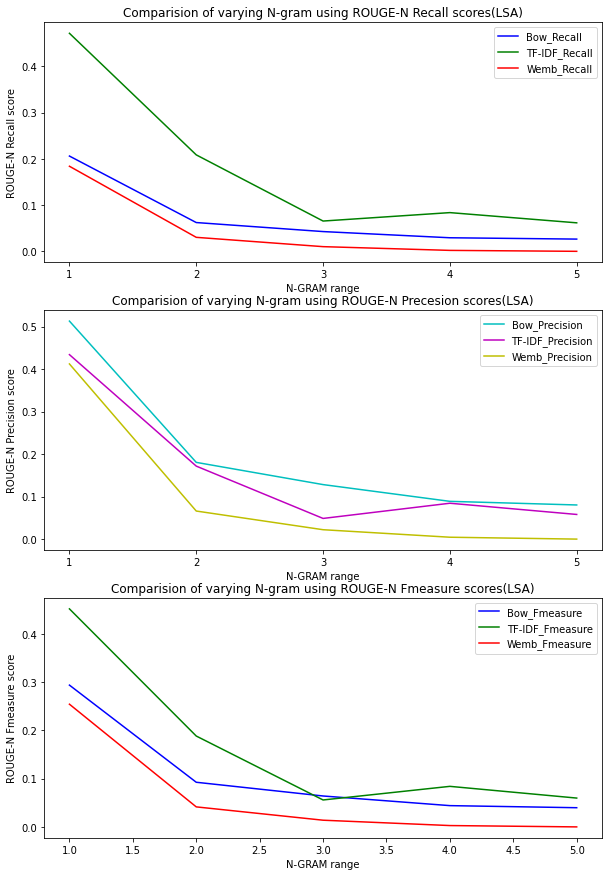

In [124]:
fig, ax = plt.subplots(3,1,figsize=(10,15))

n_gram_range = [i for i in range(1,6)]

ax[0].plot(n_gram_range,lsa_comparision_df["BOW_Recall"],'b-', label="Bow_Recall")
ax[0].plot(n_gram_range,lsa_comparision_df["TF-IDF_Recall"],'g-', label="TF-IDF_Recall")
ax[0].plot(n_gram_range,lsa_comparision_df["W-Emb_Recall"],'r-', label="Wemb_Recall")
ax[0].title.set_text("Comparision of varying N-gram using ROUGE-N Recall scores(LSA)")
ax[0].set_xlabel("N-GRAM range")
ax[0].set_xticks(n_gram_range)
ax[0].set_ylabel("ROUGE-N Recall score")
ax[0].legend(loc="best")

ax[1].plot(n_gram_range,lsa_comparision_df["BOW_Precision"],'c-', label="Bow_Precision")
ax[1].plot(n_gram_range,lsa_comparision_df["TF-IDF_Precision"],'m-', label="TF-IDF_Precision")
ax[1].plot(n_gram_range,lsa_comparision_df["W-Emb_Precision"],'y-', label="Wemb_Precision")
ax[1].title.set_text("Comparision of varying N-gram using ROUGE-N Precesion scores(LSA)")
ax[1].set_xlabel("N-GRAM range")
ax[1].set_xticks(n_gram_range)
ax[1].set_ylabel("ROUGE-N Precision score")
ax[1].legend(loc="best")

ax[2].plot(n_gram_range,lsa_comparision_df["BOW_Fmeasure"],'b-', label="Bow_Fmeasure")
ax[2].plot(n_gram_range,lsa_comparision_df["TF-IDF_Fmeasure"],'g-', label="TF-IDF_Fmeasure")
ax[2].plot(n_gram_range,lsa_comparision_df["W-Emb_Fmeasure"],'r-', label="Wemb_Fmeasure")
ax[2].title.set_text("Comparision of varying N-gram using ROUGE-N Fmeasure scores(LSA)")
ax[2].set_xlabel("N-GRAM range")
ax[1].set_xticks(n_gram_range)
ax[2].set_ylabel("ROUGE-N Fmeasure score")
ax[2].legend(loc="best")

plt.show()

### LDA

In [125]:
lda_comparision_df = pd.DataFrame()
lda_comparision_df["N-Gram Range"] = ["1-Gram", "2-Gram", "3-Gram", "4-Gram", "5-Gram"]

lda_comparision_df["BOW_Recall"] = [bow_lda_1gram_rouge.recall, bow_lda_2gram_rouge.recall, bow_lda_3gram_rouge.recall, bow_lda_4gram_rouge.recall, bow_lda_5gram_rouge.recall]
lda_comparision_df["TF-IDF_Recall"] = [tfidf_lda_1gram_rouge.recall, tfidf_lda_2gram_rouge.recall, tfidf_lda_3gram_rouge.recall, tfidf_lda_4gram_rouge.recall, tfidf_lda_5gram_rouge.recall]
lda_comparision_df["W-Emb_Recall"] = [wemb_lsa_1gram_rouge.recall, wemb_lda_2gram_rouge.recall, wemb_lda_3gram_rouge.recall, wemb_lda_4gram_rouge.recall, wemb_lda_5gram_rouge.recall]

lda_comparision_df["BOW_Precision"] = [bow_lda_1gram_rouge.precision, bow_lda_2gram_rouge.precision, bow_lda_3gram_rouge.precision, bow_lda_4gram_rouge.precision, bow_lda_5gram_rouge.precision]
lda_comparision_df["TF-IDF_Precision"] = [tfidf_lda_1gram_rouge.precision, tfidf_lda_2gram_rouge.precision, tfidf_lda_3gram_rouge.precision, tfidf_lda_4gram_rouge.precision, tfidf_lda_5gram_rouge.precision]
lda_comparision_df["W-Emb_Precision"] = [wemb_lda_1gram_rouge.precision, wemb_lda_2gram_rouge.precision, wemb_lda_3gram_rouge.precision, wemb_lda_4gram_rouge.precision, wemb_lda_5gram_rouge.precision]

lda_comparision_df["BOW_Fmeasure"] = [bow_lda_1gram_rouge.fmeasure, bow_lda_2gram_rouge.fmeasure, bow_lda_3gram_rouge.fmeasure, bow_lda_4gram_rouge.fmeasure, bow_lda_5gram_rouge.fmeasure]
lda_comparision_df["TF-IDF_Fmeasure"] = [tfidf_lda_1gram_rouge.fmeasure, tfidf_lda_2gram_rouge.fmeasure, tfidf_lda_3gram_rouge.fmeasure, tfidf_lda_4gram_rouge.fmeasure, tfidf_lda_5gram_rouge.fmeasure]
lda_comparision_df["W-Emb_Fmeasure"] = [wemb_lda_1gram_rouge.fmeasure, wemb_lda_2gram_rouge.fmeasure, wemb_lda_3gram_rouge.fmeasure, wemb_lda_4gram_rouge.fmeasure, wemb_lda_5gram_rouge.fmeasure]

lda_comparision_df

,N-Gram Range,BOW_Recall,TF-IDF_Recall,W-Emb_Recall,BOW_Precision,TF-IDF_Precision,W-Emb_Precision,BOW_Fmeasure,TF-IDF_Fmeasure,W-Emb_Fmeasure
0,1-Gram,0.175719,0.171875,0.183953,0.482456,0.434211,0.385965,0.257611,0.246269,0.290429
1,2-Gram,0.064771,0.033228,0.024169,0.180617,0.092511,0.035242,0.095349,0.048894,0.028674
2,3-Gram,0.043682,0.043956,0.009091,0.123894,0.123894,0.013274,0.064591,0.064890,0.010791
3,4-Gram,0.031898,0.030628,0.003040,0.088889,0.088889,0.004444,0.046948,0.045558,0.003610
4,5-Gram,0.028391,0.031696,0.000000,0.080357,0.089286,0.000000,0.041958,0.046784,0.000000


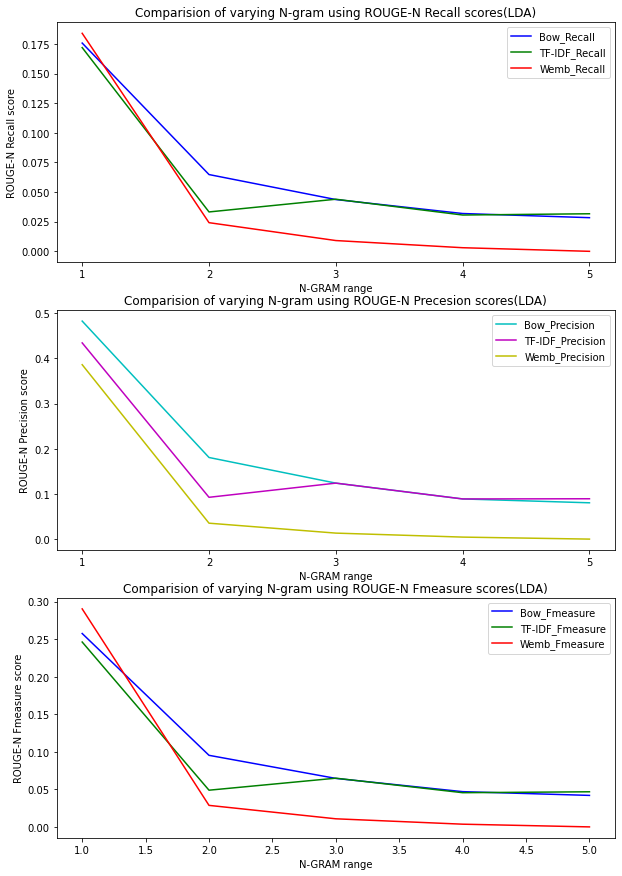

In [126]:
fig, ax = plt.subplots(3,1,figsize=(10,15))

n_gram_range = [i for i in range(1,6)]

ax[0].plot(n_gram_range,lda_comparision_df["BOW_Recall"],'b-', label="Bow_Recall")
ax[0].plot(n_gram_range,lda_comparision_df["TF-IDF_Recall"],'g-', label="TF-IDF_Recall")
ax[0].plot(n_gram_range,lda_comparision_df["W-Emb_Recall"],'r-', label="Wemb_Recall")
ax[0].title.set_text("Comparision of varying N-gram using ROUGE-N Recall scores(LDA)")
ax[0].set_xlabel("N-GRAM range")
ax[0].set_xticks(n_gram_range)
ax[0].set_ylabel("ROUGE-N Recall score")
ax[0].legend(loc="best")

ax[1].plot(n_gram_range,lda_comparision_df["BOW_Precision"],'c-', label="Bow_Precision")
ax[1].plot(n_gram_range,lda_comparision_df["TF-IDF_Precision"],'m-', label="TF-IDF_Precision")
ax[1].plot(n_gram_range,lda_comparision_df["W-Emb_Precision"],'y-', label="Wemb_Precision")
ax[1].title.set_text("Comparision of varying N-gram using ROUGE-N Precesion scores(LDA)")
ax[1].set_xlabel("N-GRAM range")
ax[1].set_xticks(n_gram_range)
ax[1].set_ylabel("ROUGE-N Precision score")
ax[1].legend(loc="best")

ax[2].plot(n_gram_range,lda_comparision_df["BOW_Fmeasure"],'b-', label="Bow_Fmeasure")
ax[2].plot(n_gram_range,lda_comparision_df["TF-IDF_Fmeasure"],'g-', label="TF-IDF_Fmeasure")
ax[2].plot(n_gram_range,lda_comparision_df["W-Emb_Fmeasure"],'r-', label="Wemb_Fmeasure")
ax[2].title.set_text("Comparision of varying N-gram using ROUGE-N Fmeasure scores(LDA)")
ax[2].set_xlabel("N-GRAM range")
ax[1].set_xticks(n_gram_range)
ax[2].set_ylabel("ROUGE-N Fmeasure score")
ax[2].legend(loc="best")

plt.show()

## Generate Features using Word-Embeddings (Next On Line)

## Reevalaute if word embeddings were generated properly (see if they were cumulated rather than, updated....  medain might work better than average...... see if the embedings can be generated as probabilites ...exponent or softmax or something)

## LDA

In [196]:
tfidf_vectorizer = TfidfVectorizer(ngram_range = (1, 1))
feature_vector = tfidf_vectorizer.fit_transform(pp_article_st)
lda_model = LDA(n_components=N_LINE, random_state=0, max_iter = 50)
document_topic = lda_model.fit_transform(feature_vector)

In [197]:
document_topic.shape

(595, 10)

In [201]:
lda_model.components_.shape

(10, 3150)

In [214]:
document_topic[0 : 5]

array([[0.02072168, 0.02071071, 0.02070818, 0.02074668, 0.81358038,
        0.02071362, 0.02070886, 0.02070441, 0.02070339, 0.0207021 ],
       [0.02152431, 0.02152846, 0.02152464, 0.02152595, 0.02152563,
        0.02152993, 0.02152312, 0.8062708 , 0.0215222 , 0.02152496],
       [0.0244328 , 0.02442974, 0.0244349 , 0.0244327 , 0.02443162,
        0.02443286, 0.02443735, 0.02443498, 0.78009677, 0.0244363 ],
       [0.02141273, 0.0214149 , 0.02142297, 0.02141523, 0.02141631,
        0.02141427, 0.80725614, 0.02141497, 0.02141324, 0.02141922],
       [0.02666964, 0.02666783, 0.75995876, 0.02667325, 0.02666786,
        0.02667204, 0.02666976, 0.02667287, 0.02666901, 0.02667898]])

In [223]:
np.argmax(document_topic[0 : 5], axis = 1)

array([4, 7, 8, 6, 2])

In [281]:
#sorted_probabilities = np.argsort(document_topic, axis = 1)[:,::-1]
sorted_probabilities = np.argsort(document_topic, axis = 1)

In [282]:
sorted_probabilities.shape

(595, 10)

In [276]:
sorted_probabilities[0 : 5]

array([[9, 8, 7, 2, 6, 1, 5, 0, 3, 4],
       [8, 6, 0, 2, 9, 4, 3, 1, 5, 7],
       [1, 4, 3, 0, 5, 2, 7, 9, 6, 8],
       [0, 8, 5, 1, 7, 3, 4, 9, 2, 6],
       [1, 4, 8, 0, 6, 5, 7, 3, 9, 2]])

In [277]:
top_probabilities = sorted_probabilities[:,-1]

In [278]:
top_probabilities[0:5]

array([4, 7, 8, 6, 2])

In [377]:
from collections import defaultdict
topic_bins = defaultdict(list)

In [378]:
for i in range(10):
  print(sorted_probabilities[i][-1], document_topic[i,sorted_probabilities[i][-1]])

4 0.8135803775862033
7 0.8062707996397139
8 0.7800967675447191
6 0.8072561448926678
2 0.7599587585378704
3 0.7464563322072268
0 0.8209721688214263
5 0.7781693909252522
6 0.8111930130605005
7 0.8432048499981545


In [379]:
#sorted_probabilities.shape[0]
for i in range(10):
  topic_num = sorted_probabilities[i][-1]
  sent_index = i
  prob = document_topic[i,sorted_probabilities[i][-1]]
  topic_bins[topic_num].append((sent_index, prob))

In [380]:
topic_bins

defaultdict(list,
            {0: [(6, 0.8209721688214263)],
             2: [(4, 0.7599587585378704)],
             3: [(5, 0.7464563322072268)],
             4: [(0, 0.8135803775862033)],
             5: [(7, 0.7781693909252522)],
             6: [(3, 0.8072561448926678), (8, 0.8111930130605005)],
             7: [(1, 0.8062707996397139), (9, 0.8432048499981545)],
             8: [(2, 0.7800967675447191)]})

In [381]:
for k, v in topic_bins.items():
  topic_bins[k] = sorted(v, key=lambda x:x[1]) 

In [382]:
topic_bins

defaultdict(list,
            {0: [(6, 0.8209721688214263)],
             2: [(4, 0.7599587585378704)],
             3: [(5, 0.7464563322072268)],
             4: [(0, 0.8135803775862033)],
             5: [(7, 0.7781693909252522)],
             6: [(3, 0.8072561448926678), (8, 0.8111930130605005)],
             7: [(1, 0.8062707996397139), (9, 0.8432048499981545)],
             8: [(2, 0.7800967675447191)]})

In [383]:
topic_bins_keys = sorted(topic_bins.keys())
topic_bin_list = [None] * 10
for tindex in topic_bins_keys:
  topic_bin_list[tindex] = topic_bins[tindex]

In [384]:
topic_bin_list

[[(6, 0.8209721688214263)],
 None,
 [(4, 0.7599587585378704)],
 [(5, 0.7464563322072268)],
 [(0, 0.8135803775862033)],
 [(7, 0.7781693909252522)],
 [(3, 0.8072561448926678), (8, 0.8111930130605005)],
 [(1, 0.8062707996397139), (9, 0.8432048499981545)],
 [(2, 0.7800967675447191)],
 None]

In [385]:
sentences = []
index = 0
while index < 10:
  #index = index % len(topic_bin_list)
  if topic_bin_list[index]:
    sentences.append(topic_bin_list[index].pop())
  index += 1


In [386]:
sentences

[(6, 0.8209721688214263),
 (4, 0.7599587585378704),
 (5, 0.7464563322072268),
 (0, 0.8135803775862033),
 (7, 0.7781693909252522),
 (8, 0.8111930130605005),
 (9, 0.8432048499981545),
 (2, 0.7800967675447191)]

In [387]:
sentences = sorted(sentences, key=lambda x:x[0])

In [388]:
sentences

[(0, 0.8135803775862033),
 (2, 0.7800967675447191),
 (4, 0.7599587585378704),
 (5, 0.7464563322072268),
 (6, 0.8209721688214263),
 (7, 0.7781693909252522),
 (8, 0.8111930130605005),
 (9, 0.8432048499981545)]

In [390]:
summary = []
for idx, prob in sentences:
  summary.append(article_st[idx])

In [391]:
summary

['\n\ncoordinates: .mw-parser-output .geo-default,.mw-parser-output .geo-dms,.mw-parser-output .geo-dec{display:inline}.mw-parser-output .geo-nondefault,.mw-parser-output .geo-multi-punct{display:none}.mw-parser-output .longitude,.mw-parser-output .latitude{white-space:nowrap}40°n 100°w\ufeff / \ufeff40°n 100°w\ufeff / 40; -100\nthe united states of america (u.s.a. or usa), commonly known as the united states (u.s. or us) or america, is a country primarily located in north america.',
 "[h] at 3.8\xa0million square miles (9.8\xa0million square kilometers), it is the world's third- or fourth-largest country by geographic area.",
 '[22] with a population of more than 331 million people, it is the third most populous country in the world.',
 'the national capital is washington, d.c., and the most populous city is new york city.',
 'paleo-indians migrated from siberia to the north american mainland at least 12,000 years ago, and european colonization began in the 16th century.',
 'the unite

In [405]:
def generate_bow_summary(raw_sent_tokens, pp_sent_tokens, summary_size = 10, ngram_tuple=(1,1)):

  #get BOW Features
  count_vectorizer = CountVectorizer(ngram_range=ngram_tuple) #intialize
  feature_vector = count_vectorizer.fit_transform(pp_sent_tokens) #generate
  print("BOW Features Generated!!!")

  #get LDA features
  lda_model = LDA(n_components=summary_size, random_state=0, max_iter = 100)
  document_topic_vector = lda_model.fit_transform(feature_vector)
  print("LDA Features Generated!!!")

  #
  #generatee summaries based on LDA probabilibities
  #

  sorted_probabilities = np.argsort(document_topic, axis = 1) 
  top_probabilities = sorted_probabilities[:,-1]
  topic_bins = defaultdict(list)

  for i in range(document_topic_vector.shape[0]):
    topic_num = sorted_probabilities[i][-1]
    sent_index = i
    prob = document_topic_vector[i,sorted_probabilities[i][-1]]
    topic_bins[topic_num].append((sent_index, prob))

  print("Topic Bins Generated!!!")

  for k, v in topic_bins.items():
    topic_bins[k] = sorted(v, key=lambda x:x[1]) 

  topic_bins_keys = sorted(topic_bins.keys())
  topic_bin_list = [None] * document_topic_vector.shape[0]
  for tindex in topic_bins_keys:
    topic_bin_list[tindex] = topic_bins[tindex]

  print("Topic Bins List Generated!!!\n")

  sentences = []
  index = 0
  count = 0
  while count < N_LINE and topic_bin_list:
    index = index % len(topic_bin_list)
    if topic_bin_list[index]:
      sentences.append(topic_bin_list[index].pop())
      count += 1
    index += 1

  sentences = sorted(sentences, key=lambda x:x[0])
  summary = []
  for idx, prob in sentences:
    summary.append(article_st[idx])

  #return "".join(summary)
  return summary

In [406]:
sum = generate_bow_summary(article_st, pp_article_st, summary_size = 20, ngram_tuple=(1,1))

BOW Features Generated!!!
LDA Features Generated!!!
Topic Bins Generated!!!
Topic Bins List Generated!!!



In [407]:
sum

['in the late 18th century, the u.s. began expanding across north america, gradually obtaining new territories, sometimes through war, frequently displacing native americans, and admitting new states; by 1848, the united states spanned the continent.',
 '[24][25] in 1538, the flemish cartographer gerardus mercator used the name "america" on his own world map, applying it to the entire western hemisphere.',
 '[30]\nthe second draft of the articles of confederation, prepared by john dickinson and completed no later than june 17, 1776, declared "the name of this confederation shall be the \'united states of america\'.',
 '[44] anthropologist henry f. dobyns believed the populations were much higher, suggesting around 1.1 million along the shores of the gulf of mexico, 2.2 million people living between florida and massachusetts, 5.2 million in the mississippi valley and tributaries, and around 700,000 people in the florida peninsula.',
 'the ensuing war would become the deadliest military 